In [1]:
%matplotlib notebook

# Benchmark Analysis

Analyze the results and performance of the benchmark model.
The results are the output of running `tasks/k_fold_evaluation.py` on the benchmark model.
[LINK TO TASK](http://localhost:8080/projects/65e4e46f1d16440bbb8e1a83403ef8f2/experiments/da6bf7d3016f4a6bb52df9223f8b74e8/execution?columns=selected&columns=type&columns=name&columns=tags&columns=status&columns=project.name&columns=users&columns=started&columns=last_update&columns=m.98dd521037fa7e551d87e8fe7b451af6.07978586e47c8709a63e895fbf3c3c7d.value.Mean.4&order=last_update)

**Performance @ top 4 accuracy: 0.488025**

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from trains import Task

from src import data_io

sns.set_style('whitegrid')
sns.set_palette('Set2')

## Prerequisites

### Data loading and preparing

In [3]:
# Load raw data, filter out trips with length of 1
raw_data = data_io.load_raw_data(trip_length_threshold=2)

# Load the true label ranks. Since a K fold scheme was done, we have for each sample in the raw data, a predicition
# and therefor a rank for the true label of that prediciton
task = Task.get_task('da6bf7d3016f4a6bb52df9223f8b74e8')
true_label_ranks = task.artifacts['true_label_ranks'].get()

In [4]:
# Merge to raw data
data = pd.merge(left=raw_data, right=true_label_ranks, on='utrip_id')
assert len(data) == len(raw_data)

In [5]:
# Add trip length column
data['trip_length'] = data.groupby('utrip_id')['user_id'].transform('count')

In [6]:
# Add week number column
data['week_number'] = data.checkin.dt.isocalendar().week

In [7]:
data

,user_id,checkin,checkout,city_id,device_class,affiliate_id,booker_country,hotel_country,utrip_id,true_label_rank,trip_length,week_number
0,1006220,2016-04-09,2016-04-11,31114,desktop,384,Gondal,Gondal,1006220_1,28776,4,14
1,1006220,2016-04-11,2016-04-12,39641,desktop,384,Gondal,Gondal,1006220_1,28776,4,15
2,1006220,2016-04-12,2016-04-16,20232,desktop,384,Gondal,Glubbdubdrib,1006220_1,28776,4,15
3,1006220,2016-04-16,2016-04-17,24144,desktop,384,Gondal,Gondal,1006220_1,28776,4,15
4,1010293,2016-07-09,2016-07-10,5325,mobile,359,The Devilfire Empire,Cobra Island,1010293_1,4202,6,27
...,...,...,...,...,...,...,...,...,...,...,...,...
1166717,999261,2016-09-13,2016-09-15,14197,tablet,10332,Gondal,Fook Island,999261_1,1,4,37
1166718,999755,2016-12-13,2016-12-16,4476,desktop,2661,The Devilfire Empire,Gondal,999755_1,5,4,50
1166719,999755,2016-12-16,2016-12-17,1034,desktop,7974,The Devilfire Empire,Gondal,999755_1,5,4,50
1166720,999755,2016-12-22,2016-12-25,64876,desktop,7974,The Devilfire Empire,Fook Island,999755_1,5,4,51


# Analysis

## Rank distribution

<IPython.core.display.Javascript object>


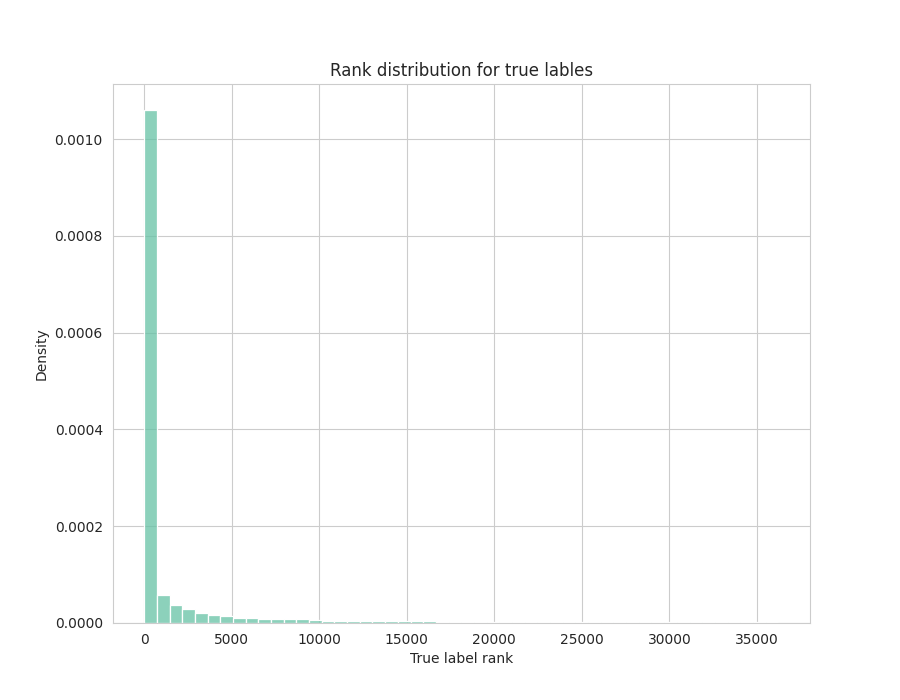

In [14]:
_, ax = plt.subplots(figsize=(9, 7))

sns.histplot(data.groupby('utrip_id')[['true_label_rank', 'week_number']].last().true_label_rank, stat='density', discrete=False, bins=50, ax=ax)

ax.set(title='Rank distribution for true lables',
       xlabel='True label rank');

## Relationship between source city and rank

<IPython.core.display.Javascript object>


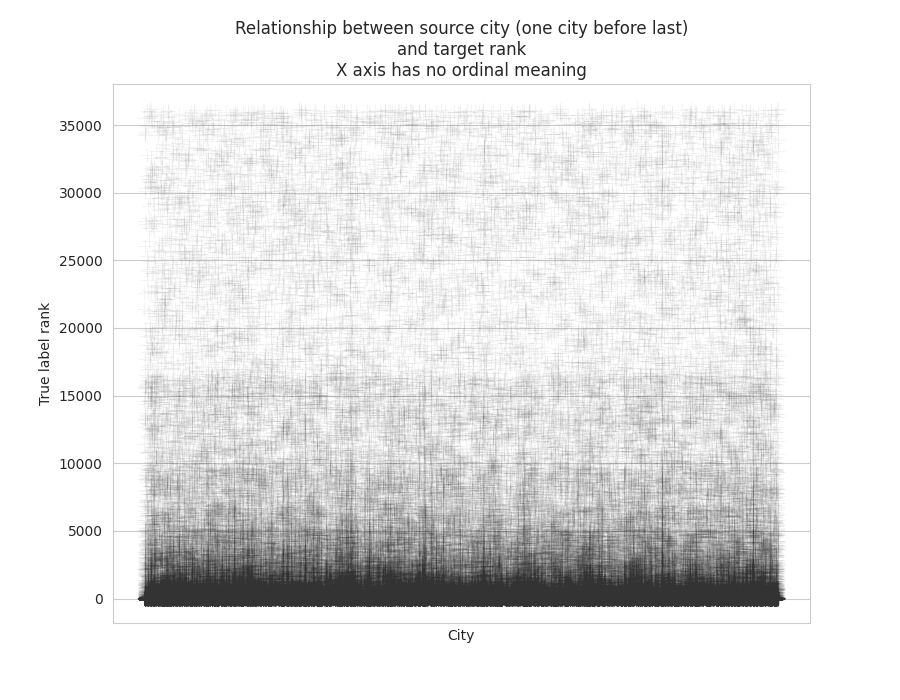

In [34]:
_, ax = plt.subplots(figsize=(9, 7))

sns.scatterplot(data=data.groupby('utrip_id')[['utrip_id', 'city_id', 'true_label_rank']].tail(2).groupby('utrip_id')[['city_id', 'true_label_rank']].first(), 
                x="city_id", 
                y="true_label_rank", s=100, color=".2", marker="+", alpha=0.05, ax=ax)

ax.xaxis.set_ticks([])

ax.set(title='Relationship between source city (one city before last)\nand target rank\nX axis has no ordinal meaning',
       xlabel='City',
       ylabel='True label rank');

## Relationship between target city and rank

<IPython.core.display.Javascript object>


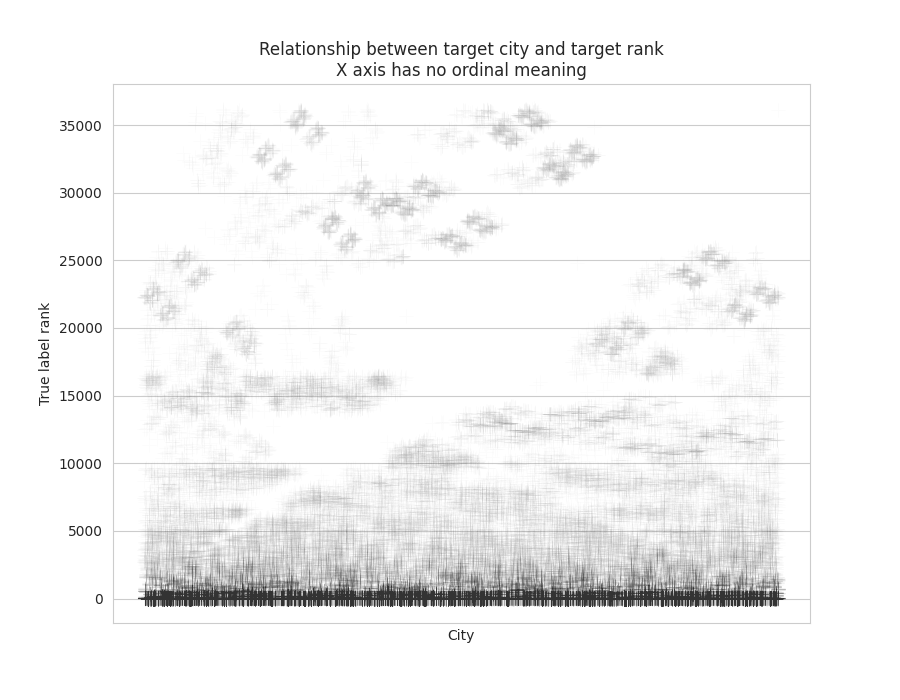

In [32]:
_, ax = plt.subplots(figsize=(9, 7))

sns.scatterplot(data=data.groupby('utrip_id')[['utrip_id', 'city_id', 'true_label_rank']].tail(2).groupby('utrip_id')[['city_id', 'true_label_rank']].last(), 
                x="city_id", 
                y="true_label_rank", s=100, color=".2", marker="+", alpha=0.01, ax=ax)

ax.xaxis.set_ticks([])

ax.set(title='Relationship between target city and target rank\nX axis has no ordinal meaning',
       xlabel='City',
       ylabel='True label rank');

## Relationship between target frequency and rank

Since the benchmark is based on travel probability between the one-before-last city and the last city, examine if the frequency of the last city in the data effects the true label rank

In [59]:
plot_data = data.groupby('utrip_id')[['city_id', 'true_label_rank']].last()
plot_data['target_frequency'] = plot_data.groupby('city_id').transform('count')

plot_data

,city_id,true_label_rank,target_frequency
utrip_id,,,
1000027_1,30628,3006,9
1000033_1,38677,0,744
1000045_1,36063,0,2946
1000083_1,36063,0,2946
100008_1,65690,0,165
...,...,...,...
999776_1,17775,1,362
999839_1,48968,2,348
999842_1,24036,776,40


<IPython.core.display.Javascript object>


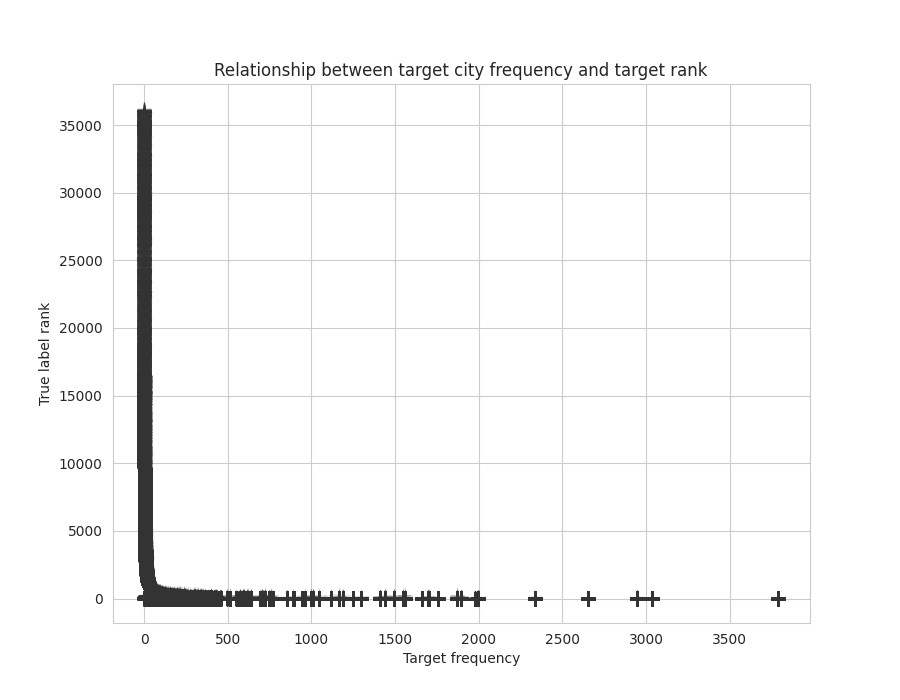

In [62]:
_, ax = plt.subplots(figsize=(9, 7))

sns.scatterplot(data=plot_data, 
                x="target_frequency",
                y="true_label_rank", s=100, color=".2", marker="+", alpha=0.1, ax=ax)

ax.set(title='Relationship between target city frequency and target rank',
       xlabel='Target frequency',
       ylabel='True label rank');

## Relationship between source frequency and rank

Same as previous plot, just now the frequency is for the one-before-last city (source)

In [39]:
plot_data = data.groupby('utrip_id')[['utrip_id', 'city_id', 'true_label_rank']].tail(2).groupby('utrip_id')[['city_id', 'true_label_rank']].first()
plot_data['source_frequency'] = plot_data.groupby('city_id').transform('count')

plot_data

,city_id,true_label_rank,source_frequency
utrip_id,,,
1000027_1,60902,3006,13
1000033_1,27485,0,65
1000045_1,58178,0,459
1000083_1,35160,0,63
100008_1,6779,0,211
...,...,...,...
999776_1,17775,1,205
999839_1,8335,2,169
999842_1,67169,776,40


<IPython.core.display.Javascript object>


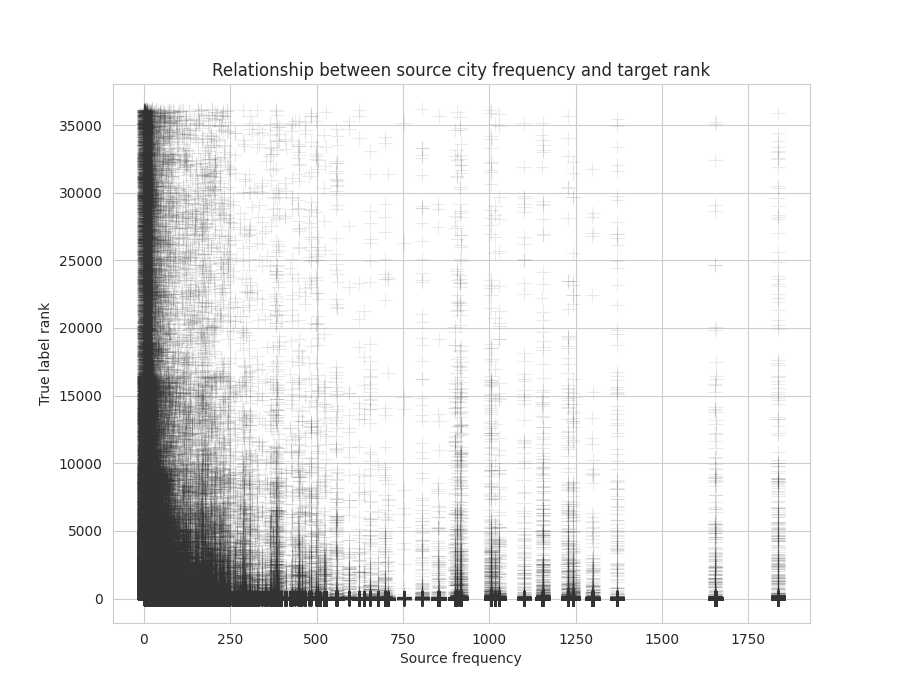

In [40]:
_, ax = plt.subplots(figsize=(9, 7))

sns.scatterplot(data=plot_data, 
                x="source_frequency", 
                y="true_label_rank", s=100, color=".2", marker="+", alpha=0.1, ax=ax)

ax.set(title='Relationship between source city frequency and target rank',
       xlabel='Source frequency',
       ylabel='True label rank');

## Relationship between week number and rank

<IPython.core.display.Javascript object>


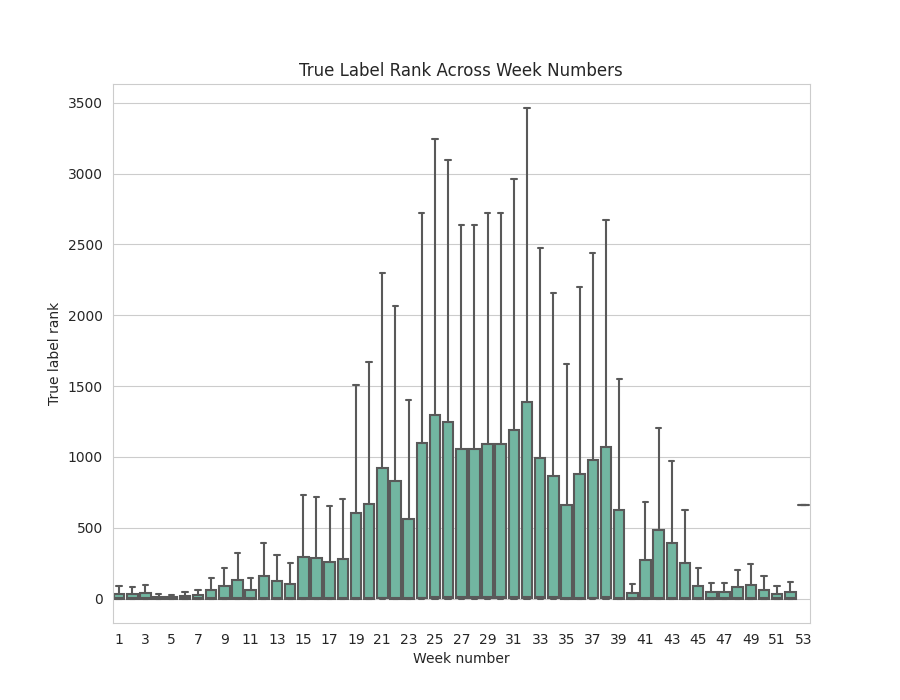

In [25]:
_, ax = plt.subplots(figsize=(9, 7))

ax = sns.boxplot(x='week_number', y='true_label_rank', 
                 data=data.groupby('utrip_id')[['true_label_rank', 'week_number']].last(), 
                 showfliers = False,
                 color=sns.color_palette()[0])

ax.xaxis.set_ticks(np.arange(0,53, 2))
ax.set(title='True Label Rank Across Week Numbers',
       xlabel='Week number',
       ylabel='True label rank');

## Relationship between trip length and rank

<IPython.core.display.Javascript object>


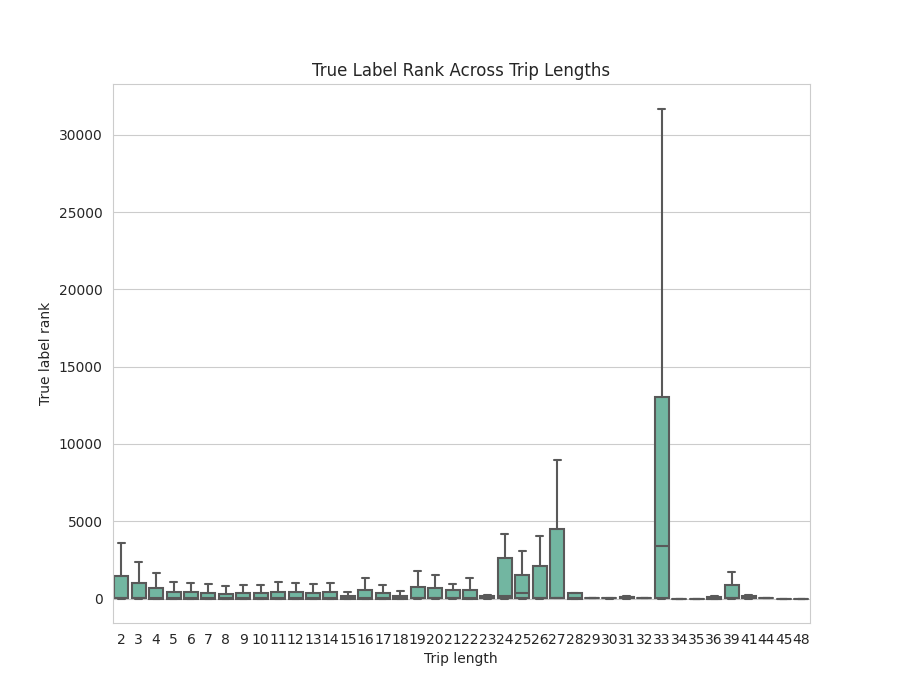

In [27]:
_, ax = plt.subplots(figsize=(9, 7))

ax = sns.boxplot(x='trip_length', y='true_label_rank', 
                 data=data.groupby('utrip_id')[['true_label_rank', 'trip_length']].last(), 
                 showfliers = False,
                 color=sns.color_palette()[0])

ax.set(title='True Label Rank Across Trip Lengths',
       xlabel='Trip length',
       ylabel='True label rank');

<IPython.core.display.Javascript object>


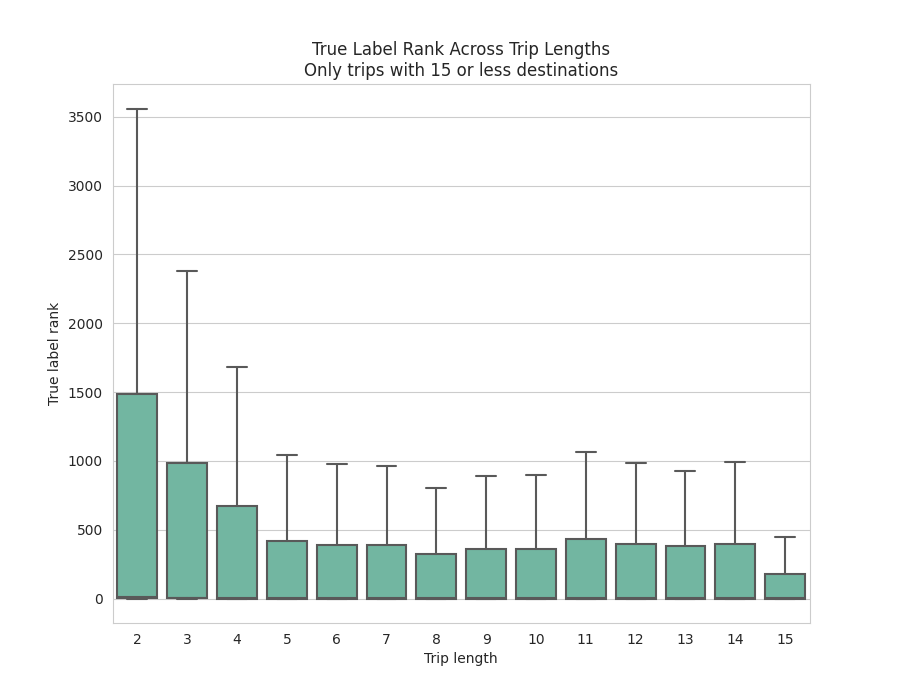

In [28]:
_, ax = plt.subplots(figsize=(9, 7))

# Filter to trips with 15 or less destinations
plot_data = data.groupby('utrip_id')[['true_label_rank', 'trip_length']].last()
plot_data = plot_data[plot_data.trip_length <= 15]

ax = sns.boxplot(x='trip_length', y='true_label_rank', 
                 data=plot_data, 
                 showfliers = False,
                 color=sns.color_palette()[0])

ax.set(title='True Label Rank Across Trip Lengths\nOnly trips with 15 or less destinations',
       xlabel='Trip length',
       ylabel='True label rank');

## Relationship between booker country and 

<IPython.core.display.Javascript object>


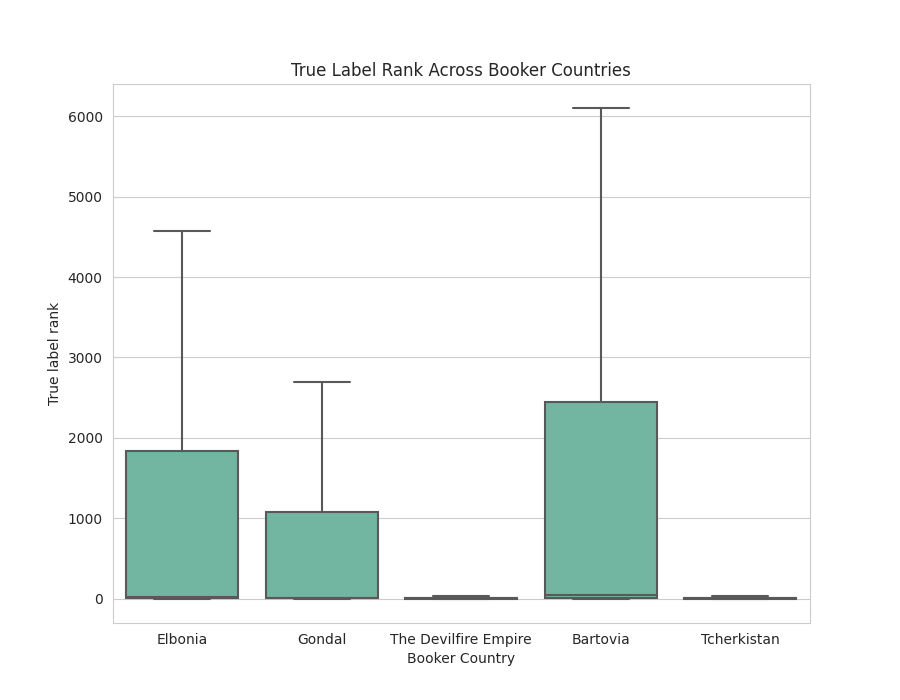

In [13]:
_, ax = plt.subplots(figsize=(9, 7))

ax = sns.boxplot(x='booker_country', y='true_label_rank', 
                 data=data.groupby('utrip_id')[['true_label_rank', 'booker_country']].last(), 
                 showfliers = False,
                 color=sns.color_palette()[0])

ax.set(title='True Label Rank Across Booker Countries',
       xlabel='Booker Country',
       ylabel='True label rank');

<IPython.core.display.Javascript object>


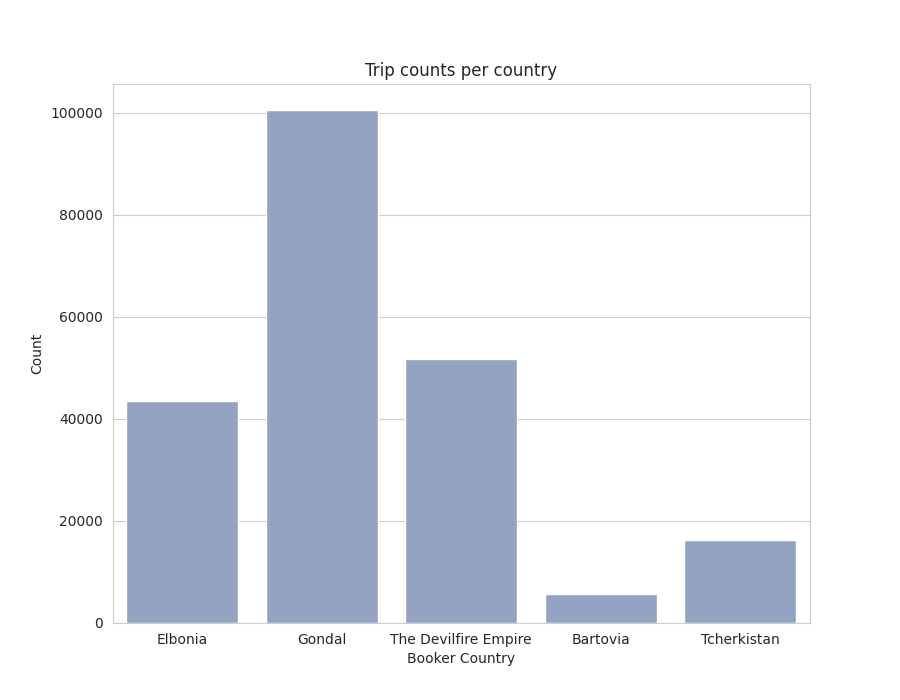

In [18]:
_, ax = plt.subplots(figsize=(9, 7))

sns.countplot(x=data.groupby('utrip_id')[['booker_country']].last().booker_country, 
              ax=ax, color=sns.color_palette()[2])

ax.set(title='Trip counts per country',
       xlabel='Booker Country',
       ylabel='Count');